<a href="https://colab.research.google.com/github/aai510-group1/project/blob/main/Final Project Section3-Team 1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project Section3 -Team 1

Team Members:
- Jon Augustin
- Dina Shalaby
- Paul Parks
 

## Includes

In [ ]:
!apt-get install -qqq --no-install-recommends graphviz libgraphviz-dev

# USE uv FOR FASTER PIP INSTALLS
%pip install --quiet --progress-bar=off uv

# INSTALL DEPENDENCIES
!uv pip uninstall --system --quiet bokeh mkl
!uv pip install --system --quiet --upgrade pip
!uv pip install --system --quiet --upgrade black[jupyter] bokeh datasets isort pygraphviz setuptools wheel
!uv pip install --system --quiet autogluon numpy==1.24.4 shap

In [ ]:
# @title Create a Folder in Google Drive and Enable Top-Level Access in the File Browser { display-mode: "form" }
def setup_drive_folder(google_drive_folder):
    import contextlib, google.colab, os, pathlib
    if not google_drive_folder:
        google_drive_folder = "temp"
    with contextlib.redirect_stdout(open(os.devnull, 'w')):
        google.colab.drive.mount("/content/drive", force_remount=True)
    drive_path = pathlib.Path("/content/drive/MyDrive")
    colab_notebooks_path = drive_path / "Colab Notebooks"
    project_path = colab_notebooks_path / google_drive_folder
    project_path.mkdir(parents=True, exist_ok=True)
    shortcut = pathlib.Path(f"/content/{google_drive_folder}")
    shortcut.parent.mkdir(parents=True, exist_ok=True)
    if not shortcut.exists():
        shortcut.symlink_to(project_path)
    print(f"SHORTCUT: {shortcut} --> {project_path}")
    return str(shortcut)

google_drive_folder = "aai510-group1"  # @param { type: "string" }
SHORTCUT = setup_drive_folder(google_drive_folder)

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from autogluon.tabular import TabularPredictor

## Dataset


In [59]:
df = pd.read_csv('./Dataset/dataset.csv')
df.head()

,Age,Avg Monthly GB Download,Avg Monthly Long Distance Charges,Churn Category,Churn Label,Churn Reason,Churn Score,Churn Value,City,CLTV,...,Streaming TV,Tenure in Months,Total Charges,Total Extra Data Charges,Total Long Distance Charges,Total Refunds,Total Revenue,Under 30,Unlimited Data,Zip Code
0,78,8,0.00,Competitor,Yes,Competitor offered more data,91,1,Los Angeles,5433,...,No,1,39.65,20,0.00,0.0,59.65,No,No,90022
1,39,18,42.55,NaN,No,NaN,42,0,Los Angeles,4658,...,No,72,5016.65,0,3063.60,0.0,8080.25,No,Yes,90022
2,32,26,7.11,NaN,No,NaN,34,0,Los Angeles,3503,...,No,1,75.55,0,7.11,0.0,82.66,No,Yes,90022
3,35,25,0.00,NaN,No,NaN,46,0,Los Angeles,5748,...,Yes,66,3708.40,0,0.00,0.0,3708.40,No,Yes,90022
4,20,42,36.49,NaN,No,NaN,38,0,Los Angeles,5545,...,Yes,7,633.45,0,255.43,0.0,888.88,Yes,Yes,90022


Drop target and leakage variables

In [60]:
# drop customer ID , Count, Country , State since they are not relevant to the analysis. All in US, CA
df.drop(columns=['Customer ID','Country','State'], inplace=True)
# drop variables that are leaking the Target variable
df.drop(columns=['Churn Label','Churn Score','Churn Reason','Churn Category','Customer Status'], inplace=True)

Encoding

In [61]:
# find non-numerical features and convert to numerical features
# Find non-numerical features
non_numerical_features = df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate through each non-numerical feature and perform label encoding
for feature in non_numerical_features:
    df[feature] = label_encoder.fit_transform(df[feature])


# Display the first few rows after label encoding
print("First 5 rows after label encoding:")
print(df.head())

First 5 rows after label encoding:
   Age  Avg Monthly GB Download  Avg Monthly Long Distance Charges  \
0   78                        8                               0.00   
1   39                       18                              42.55   
2   32                       26                               7.11   
3   35                       25                               0.00   
4   20                       42                              36.49   

   Churn Value  City  CLTV  Contract  Dependents  Device Protection Plan  \
0            1   554  5433         0           0                       1   
1            0   554  4658         2           0                       1   
2            0   554  3503         0           0                       1   
3            0   554  5748         2           1                       1   
4            0   554  5545         1           0                       0   

   Gender  ...  Streaming TV  Tenure in Months  Total Charges  \
0       1  ...        

## Exploratory Data Analysis

Statistics:

In [62]:
# Summary statistics
print("Summary statistics:")
print(df.describe())

Summary statistics:
               Age  Avg Monthly GB Download  \
count  7043.000000              7043.000000   
mean     46.509726                20.515405   
std      16.750352                20.418940   
min      19.000000                 0.000000   
25%      32.000000                 3.000000   
50%      46.000000                17.000000   
75%      60.000000                27.000000   
max      80.000000                85.000000   

       Avg Monthly Long Distance Charges  Churn Value         City  \
count                        7043.000000  7043.000000  7043.000000   
mean                           22.958954     0.265370   588.042879   
std                            15.448113     0.441561   307.797647   
min                             0.000000     0.000000     0.000000   
25%                             9.210000     0.000000   331.000000   
50%                            22.890000     0.000000   604.000000   
75%                            36.395000     1.000000   854.000000

Check for missing values

In [63]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values:")
print(missing_values)


Missing values:
Age                                  0
Avg Monthly GB Download              0
Avg Monthly Long Distance Charges    0
Churn Value                          0
City                                 0
CLTV                                 0
Contract                             0
Dependents                           0
Device Protection Plan               0
Gender                               0
Internet Service                     0
Internet Type                        0
Lat Long                             0
Latitude                             0
Longitude                            0
Married                              0
Monthly Charge                       0
Multiple Lines                       0
Number of Dependents                 0
Number of Referrals                  0
Offer                                0
Online Backup                        0
Online Security                      0
Paperless Billing                    0
Partner                              0
Payment 

Correlation heatmap

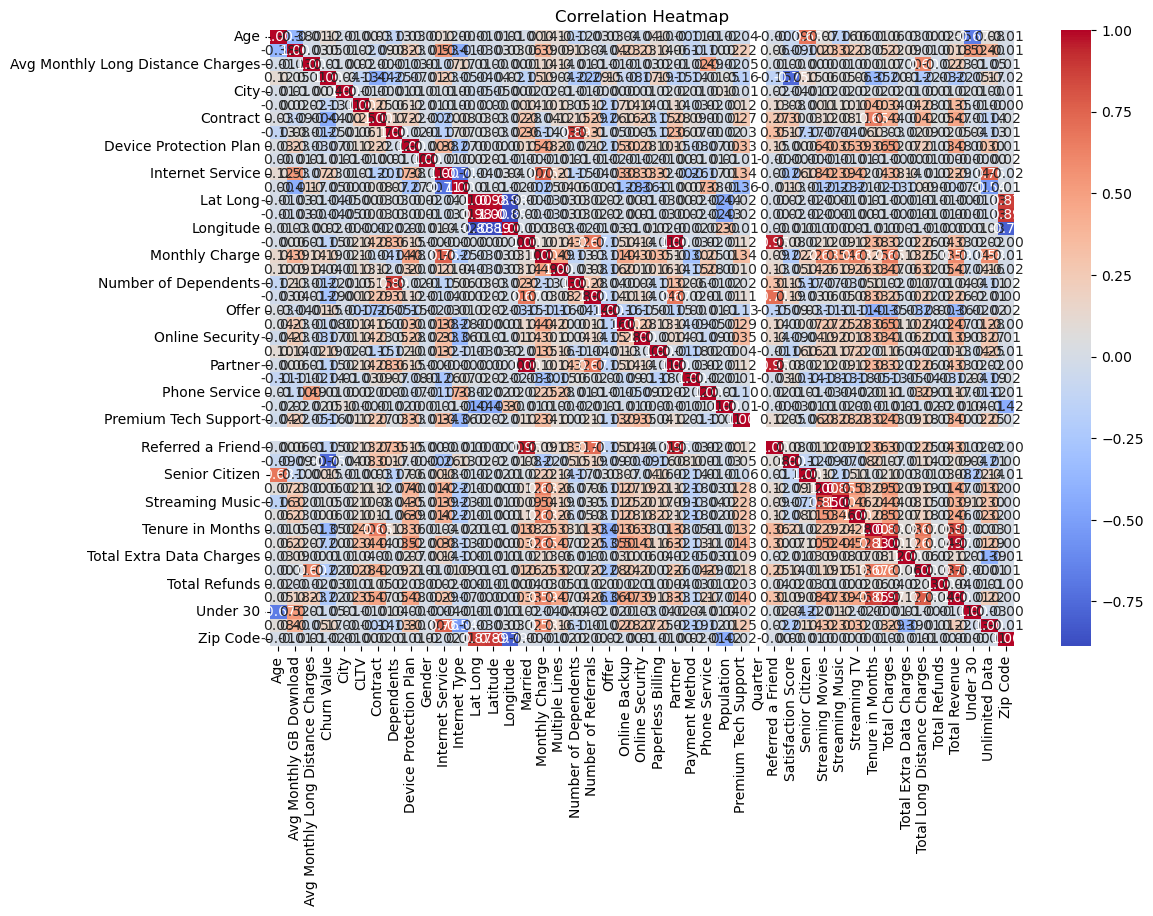

In [64]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Distribution of numerical features

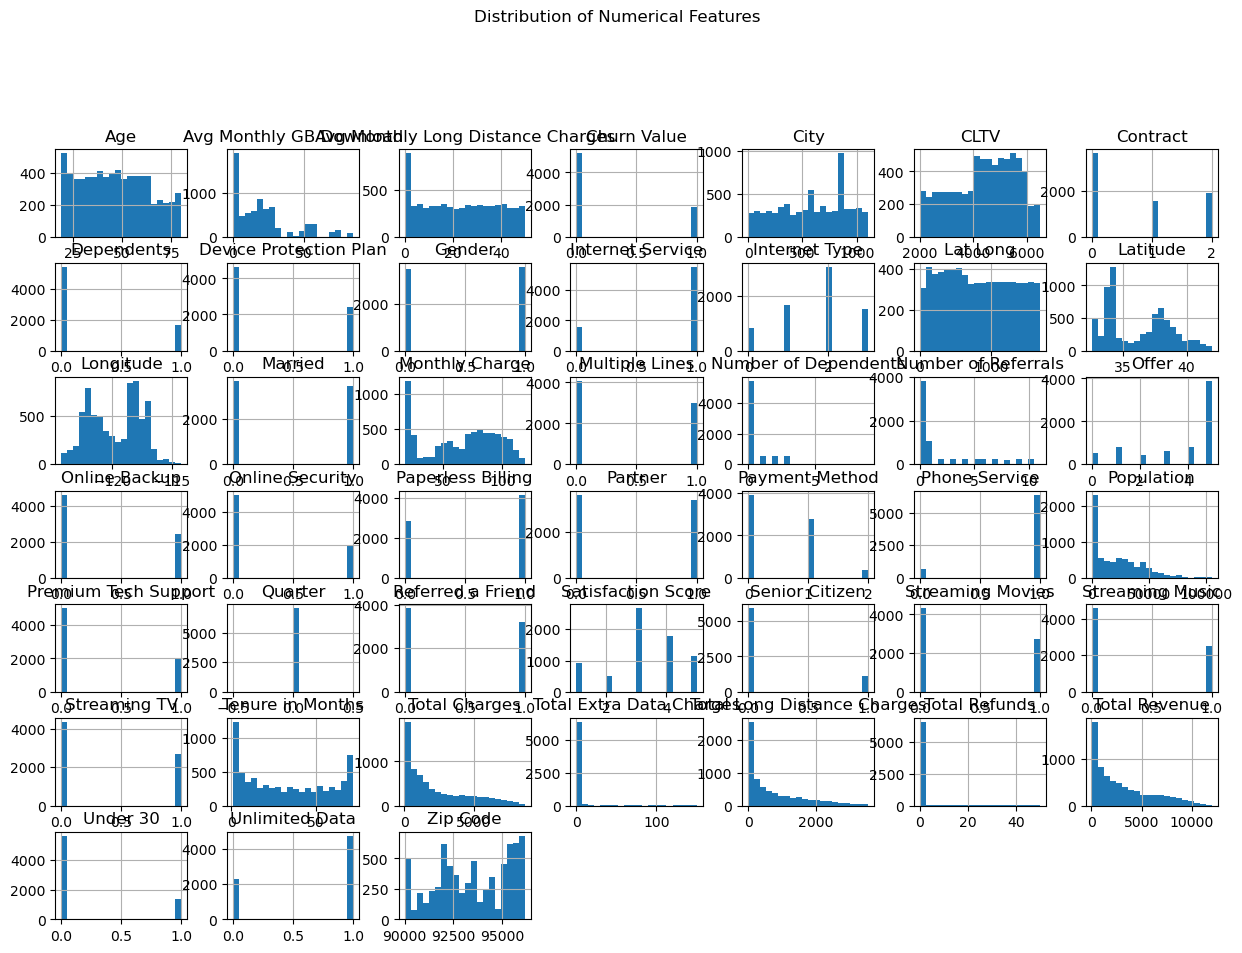

In [65]:
# Distribution of numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
df[numerical_features].hist(bins=20, figsize=(15, 10))
plt.suptitle('Distribution of Numerical Features', x=0.5, y=1.02, ha='center', fontsize='large')
plt.show()

View some of the interesting feature distributions

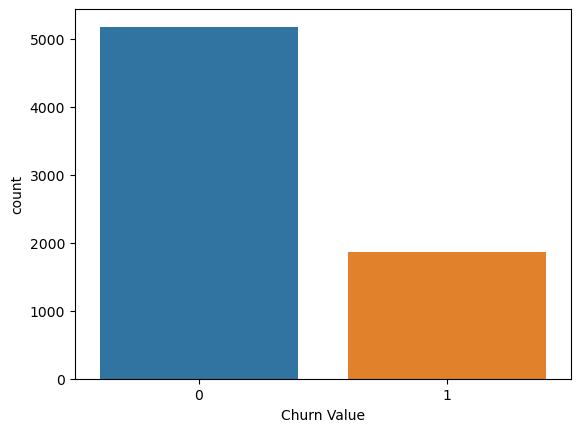

In [66]:
sns.countplot(x='Churn Value', data=df)
plt.show()

/Users/pparks/anaconda3/envs/msaai-1/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


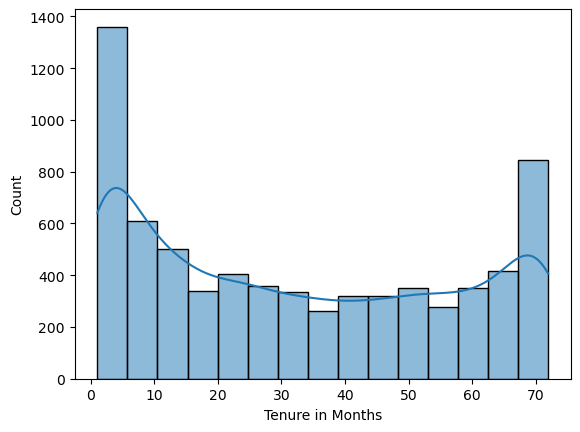

In [67]:
sns.histplot(df['Tenure in Months'], kde=True)
plt.show()

/Users/pparks/anaconda3/envs/msaai-1/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


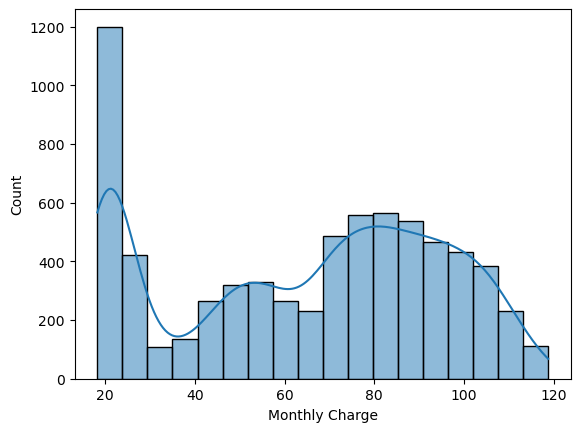

In [68]:
sns.histplot(df['Monthly Charge'], kde=True)
plt.show()

# Baseline Model

## Setup testing and training data

In [69]:
# Split the data into features (X) and target variable (y)
X = df.drop(columns=['Churn Value'])
y = df['Churn Value']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Create a helper function for training and evaluation

In [70]:
def fit_predict_evaluate(model, X_train, y_train, X_test, y_test):
    # Fit the model
    model.fit(X_train, y_train)

    # Predict the target vector
    dt_y_pred = model.predict(X_test)
    
    # Evaluate Decision Tree model
    dt_accuracy = accuracy_score(y_test, dt_y_pred)
    dt_precision = precision_score(y_test, dt_y_pred)
    dt_recall = recall_score(y_test, dt_y_pred)
    dt_f1 = f1_score(y_test, dt_y_pred)
    dt_conf_matrix = confusion_matrix(y_test, dt_y_pred)
    dt_roc_auc = roc_auc_score(y_test, dt_y_pred)
    print(f"Accuracy: {dt_accuracy}")
    print(f"Precision: {dt_precision}")
    print(f"Recall: {dt_recall}")
    print(f"F1 Score: {dt_f1}")
    print(f"Confusion Matrix:{dt_conf_matrix}")
    print(f'AUC: {dt_roc_auc }')
    print(dt_conf_matrix)

## Create a DecisionTreeClassifier to gather baseline metrics

In [71]:
# Baseline Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)

print("Baseline Decision Tree Model:")
fit_predict_evaluate(dt_model, X_train, y_train, X_test, y_test)

Baseline Decision Tree Model:
Accuracy: 0.9410929737402413
Precision: 0.875
Recall: 0.9098143236074271
F1 Score: 0.8920676202860858
Confusion Matrix:[[983  49]
 [ 34 343]]
AUC: 0.9311668517261941
[[983  49]
 [ 34 343]]


## XGBoost

In [72]:
xgb_model = XGBClassifier()

print("XGBoost Classifier:")
fit_predict_evaluate(xgb_model, X_train, y_train, X_test, y_test)

XGBoost Classifier:
Accuracy: 0.957416607523066
Precision: 0.9490084985835694
Recall: 0.8885941644562334
F1 Score: 0.9178082191780822
Confusion Matrix:[[1014   18]
 [  42  335]]
AUC: 0.9355761519955584
[[1014   18]
 [  42  335]]


## Hyperparam to optimize Xgboost

In [73]:
 #Define parameter grid for Grid Search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

# Initialize XGBoost classifier
xgb_model = XGBClassifier()

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Predict using the best model
best_xgb_model = grid_search.best_estimator_

print("Best XGBoost Model:")
fit_predict_evaluate(best_xgb_model, X_train, y_train, X_test, y_test)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50}
Best Score: 0.966276806498335
Best XGBoost Model:
Accuracy: 0.9581263307310149
Precision: 0.9517045454545454
Recall: 0.8885941644562334
F1 Score: 0.9190672153635117
Confusion Matrix:[[1015   17]
 [  42  335]]
AUC: 0.9360606481195896
[[1015   17]
 [  42  335]]


## Predicting using Deep Neural Networks

In [74]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the deep neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model on the test set
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)


# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Deep Neural Network Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

45/45 [==============================] - 0s 268us/step
Deep Neural Network Metrics:
Accuracy: 0.9488999290276792
Precision: 0.9155313351498637
Recall: 0.8912466843501327
F1 Score: 0.9032258064516129
Confusion Matrix:
[[1001   31]
 [  41  336]]


## Model Comparison

### Summary of Model Performance

#### Baseline Decision Tree Model
- **Accuracy**: 0.9411
- **Precision**: 0.875
- **Recall**: 0.9098
- **F1 Score**: 0.8921
- **Confusion Matrix**:
  - True Positives (TP): 343
  - True Negatives (TN): 983
  - False Positives (FP): 49
  - False Negatives (FN): 34
- **AUC**: 0.9312

#### Best XGBoost Model
- **Accuracy**: 0.9581
- **Precision**: 0.9517
- **Recall**: 0.8886
- **F1 Score**: 0.9191
- **Confusion Matrix**:
  - True Positives (TP): 335
  - True Negatives (TN): 1015
  - False Positives (FP): 17
  - False Negatives (FN): 42
- **AUC**: 0.9361

#### Deep Neural Network Metrics
- **Accuracy**: 0.9489
- **Precision**: 0.9155
- **Recall**: 0.8912
- **F1 Score**: 0.9032
- **Confusion Matrix**:
  - True Positives (TP): 336
  - True Negatives (TN): 1001
  - False Positives (FP): 31
  - False Negatives (FN): 41

### Summary

1. **Accuracy**:
   - XGBoost has the highest accuracy (0.9581)

2. **Precision**:
   - XGBoost shows the highest precision (0.9517)

3. **Recall**:
   - The Decision Tree has the highest recall (0.9098)

4. **F1 Score**:
   - XGBoost has the highestF1 score of 0.9191

5. **AUC**:
   - XGBoost also has the highest AUC (0.9361)

6. **Confusion Matrix**:
   - XGBoost has the least number of false positives (17) and a lower number of false negatives (42) compared to the Decision Tree and Deep Neural Network.
   - The Deep Neural Network has a slightly better balance between false positives (31) and false negatives (41) compared to the Decision Tree.

### Conclusion

- **XGBoost** stands out as the best-performing model overall, with the highest accuracy, precision, F1 score, and AUC, though its recall is slightly lower than the Decision Tree.
- **Deep Neural Network** offers a good balance, with strong precision and recall, resulting in a high F1 score.
- **Decision Tree** has the highest recall, making it a good choice for applications where catching all positives is crucial, despite having the lowest precision and F1 score among the three.


## Best Model

In [ ]:
# LOAD MERGED TELCO CUSTOMER DATASET
from datasets import load_dataset
dataset = load_dataset('aai510-group1/telco-customer-churn', token=False)

# CONVERT DATASETS TO PANDAS DATAFRAMES
df_train = dataset['train'].to_pandas()
df_test = dataset['test'].to_pandas()
df_val = dataset['validation'].to_pandas()

In [ ]:
import os
from autogluon.tabular import TabularPredictor

TARGET_LABEL = "Churn"
EVAL_METRIC = "roc_auc"
DPI = 300
PRESETS = [
    "best_quality",
    "optimize_for_deployment",
]
LEAKED_FEATURES = [
    "Churn Category",
    "Churn Reason",
    "Churn Score",
    "Customer Status",
]

predictor = TabularPredictor(
    eval_metric=EVAL_METRIC,
    label=TARGET_LABEL,
    learner_kwargs={"ignored_columns": LEAKED_FEATURES},
    verbosity=3,
).fit(
    df_train,
    dynamic_stacking=False,
    presets=PRESETS,
    time_limit=3600,
    tuning_data=df_val,
    use_bag_holdout=True,
)

In [ ]:
import os
import matplotlib.pyplot as plt

# SAVE TRAINING SUMMARY
results = predictor.fit_summary(verbosity=3)
with open(os.path.join(predictor.path, "fit_summary.txt"), "w") as f:
    f.write(str(results))

# SAVE ENSEMBLE ARCHITECTURE
predictor.plot_ensemble_model()

In [ ]:
!cp -r /content/AutogluonModels {SHORTCUT}

## Deployment

## Conclusion

## colab2pdf

In [ ]:
def colab2pdf():
    # Colab2PDF by Drengskapur (https://github.com/drengskapur/colab2pdf)
    # @title Convert Colab Notebook to PDF {display-mode:'form'}
    # VERSION 1.4
    # LICENSE: GPL-3.0-or-later
    !apt-get install -yqq --no-install-recommends librsvg2-bin>/dev/null
    import contextlib,datetime,google,io,IPython,ipywidgets,json,locale,nbformat,os,pathlib,requests,urllib,warnings,werkzeug,yaml;locale.setlocale(locale.LC_ALL,'en_US.UTF-8')
    def convert(b):
        try:
            s.value='⚙️ Converting...';b.disabled=True;get_ipython().events.register('post_execute',lambda:IPython.display.display(IPython.display.Javascript('document.querySelectorAll("#output-footer").forEach(footer=>footer.remove());')))
            n=pathlib.Path(werkzeug.utils.secure_filename(urllib.parse.unquote(requests.get(f'http://{os.environ["COLAB_JUPYTER_IP"]}:{os.environ["KMP_TARGET_PORT"]}/api/sessions').json()[0]['name'])))
            p=pathlib.Path('/content/pdfs')/f'{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}_{n.stem}';p.mkdir(parents=True,exist_ok=True);warnings.filterwarnings('ignore',category=nbformat.validator.MissingIDFieldWarning)
            nb=[cell for cell in nbformat.reads(json.dumps(google.colab._message.blocking_request('get_ipynb',timeout_sec=600)['ipynb']),as_version=4).cells if '--Colab2PDF' not in cell.source]
            with (p/f'{n.stem}.ipynb').open('w',encoding='utf-8') as cp:nbformat.write(nbformat.v4.new_notebook(cells=nb or [nbformat.v4.new_code_cell('#')]),cp)
            with (p/'config.yml').open('w',encoding='utf-8') as f:yaml.dump({'include-in-header':[{'text':r'\usepackage{fvextra}\DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines,breakanywhere,commandchars=\\\{\}}'}],'include-before-body':[{'text':r'\DefineVerbatimEnvironment{verbatim}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines}'}]},f)
            !quarto render {p}/{n.stem}.ipynb --metadata-file={p}/config.yml --to pdf -M latex-auto-install -M margin-top=1in -M margin-bottom=1in -M margin-left=1in -M margin-right=1in --quiet
            google.colab.files.download(str(p/f'{n.stem}.pdf'));s.value=f'🎉 Downloaded {n.stem}.pdf'
        except Exception as e:
            s.value=f'⚠️ ERROR {str(e)}'
        finally:
            b.disabled=False
    if not pathlib.Path('/usr/local/bin/quarto').exists():
        !wget -q 'https://quarto.org/download/latest/quarto-linux-amd64.deb' && dpkg -i quarto-linux-amd64.deb>/dev/null && quarto install tinytex --update-path --quiet && rm quarto-linux-amd64.deb
    b=ipywidgets.widgets.Button(description='⬇️ Download PDF');s=ipywidgets.widgets.Label();b.on_click(lambda b:convert(b));IPython.display.display(ipywidgets.widgets.HBox([b,s]))
    IPython.display.display(IPython.display.Javascript('document.currentScript.parentElement.closest(".output_subarea").querySelector("#output-footer > input").remove();'))
colab2pdf()